## Let's build a binary classifier with our micrograd engine!

Below, I take Andrej's example and expound on it with my notes about the code. You won't understand all of it just from the series of lectures, but it runs on what we already went through, although the code is slightly different, you should be able to understand what is going on, especially if you test with different outputs along the way.

In [43]:
# This code is adapted from [Andrei Karpathy]
# Copyright (c) [2020] [Andrei Karpathy]

import random
import numpy as np
import matplotlib.pyplot as plot
%matplotlib inline

In [44]:
#import the micrograd we made
from micrograd.engine import Value 
from micrograd.mlp import Neuron, Layer, MLP

In [45]:
#set random seeds for reproducibility. Numpy and random both have seeds set.
#every time the code is run, it will generate the same random numbers, 
#which means that the dataset and any other random operations produce the same results
np.random.seed(1337)
random.seed(1337)

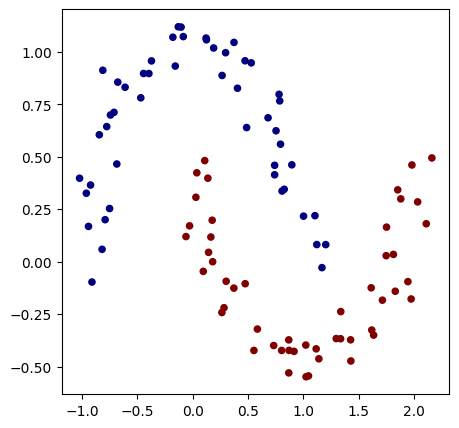

In [46]:
from sklearn.datasets import make_moons, make_blobs

# create dataset using 'make_moons' from sklearn
# generates synthetic dataset with two interleaving half circles shape
X, y = make_moons(n_samples=100, noise=0.1) #adds gaussian noise to the data

# make y axis to be -1 to 1 instead of 0 to 1 (default)
y = y * 2 - 1 

# print dataset in 2D
plot.figure(figsize=(5,5)) #figure width/height in inches

# creates scatter plot of data with x and y coordinates. c=y sets color based on labels; s is size of the points, cmap=jet is colormap
plot.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

### ReLU

Below, we initialize the neural network, which will be made with the micrograd I created in this repository. It is made with a ```ReLU``` function instead of a ```tanh()``` activation function, as Andrei coded his this way in his final product. 

Recall from the notebooks that without an activation functions to introduce non-linearity into the network, the network would not be able to learn complex patterns and functions; it would simply be equivalent to a single-layer lienar model, which would limit its modeling power. Activation functions enable stacking of multiple layers, where each layer learns different levels of abstraction. Different activation functions can control the range of the output values. 

After some research, here is the theory behind why we implemented ```ReLU()``` in micrograd and are using it here:

### ```tanh(): Hyperbolic Tangent```

$$tanh(x)={\frac {\sinh x}{\cosh x}}={\frac {e^{x}-e^{-x}}{e^{x}+e^{-x}}}={\frac {e^{2x}-1}{e^{2x}+1}}$$

### ```ReLU(): Rectified Linear Unit```

$$ReLU(x)={max(0, x)}$$

- While ```tanh()``` outputs between -1 and 1, ```ReLU``` outputs $0$ for any negative input and the input itself for any positive input

- In the backward pass, ```tanh()```'s derivativce is $1-tanh(x)^2$, which can lead to small gradients for large values of $x$, potentially causing ```vanishing gradients```. The ```ReLU```'s derivative is $1$ for positive outputs and $0$ for negative inputs, making gradient calculation straightforward.

- ```vanishing gradients```: when the gradients of the loss function with respect to the model parameters become very small, effectively approaching zero. This can severely slow down or even stop the training process becasue the updates to the model parameters become insignificant.
  
- For ```tanh()```, when the input values are are very large or very small, ```tanh(x)``` saturates to $-1$ or $1$, making the gradient close to $0$. Since these gradients get mutliplied through each layer, it results in exponentially smaller gradients continually, which makes it tough for the model to learn.

- For ```ReLU()```, it doesn't squash the gradients into a small range, so it doesn't have this problem. It suffers from a different problem, however, known as the ```dying ReLU``` porblem, where neurons get stuck with a gradient of $0$ if they always output $0$.

- Note: another common activation function is ```sigmoid(x)```, which outputs values between $0$ and $1$, and is useful for binary classification, although they can also suffer from the vanishing gradient problem. Its function is 
$${\frac {1}{1 + {e^{-x}}}}$$

In [34]:
model = MLP(2, [16, 16, 1]) # 2-layer neural network: 2 inputs, 2 hidden layers with 16 

print("parameter count: ", len(model.parameters()))

parameter count:  337


In [47]:
# loss function
def loss(batch_size=None): #compare predictions to labels. Xb = data; yb = labels
    
    #batch selection
    if batch_size is None:
        Xb, yb = X, y # Use the entire dataset
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size] # randomly select a batch of batch_size, if specified
        Xb, yb = X[ri], y[ri] #randomly select a subset of the data
        
    inputs = [list(map(Value, xrow)) for xrow in Xb] # Convert input rows to Value objects for automatic differentiation
    
    #passing the inputs through the model to compute the scores (predictions)
    #map function applies a given function (model; an mlp instance) to each item of an iterable(inputs; list of input vectors) and returns an iterator (object)
    scores = list(map(model, inputs))
    
    # calculates "max-margin" loss for each prediction and applies ReLU(). 
    #for each y and score for the given x input to mlp, calculate loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses)) #dataloss = average of these individual losses
    
    #adds an L2 regularization term to the loss to prevent overfitting
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters())) #regularization term: alpha * sum of p^2 for all params p in model
    total_loss = data_loss + reg_loss #total loss = sum of data loss and regularization loss
    
    #calculate accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)] #comparing signs of labels yi and predictions scorei
    return total_loss, sum(accuracy) / len(accuracy) #return loss and accuracy

total_loss, acc = loss() #compute total loss and accuracy for current model state
print(total_loss, acc)

Value(data=0.026057747815595975) 1.0


## Explanation:

### Margin-Based Loss:

This loss function is based on the hinge loss, commonly used for support vector machines (SVMs) and other classifiers. The hinge loss for a single prediction is defined as:

$loss = max(0,1 - y[i] * score[i])$

where $y[i]$ is the true label, and $score[i]$ is the predicted score.

### True Labels ($y[i]$)):

For binary classification, the true labels are typically either $+1$ or $-1$. In this example, $( yb[0] = 1 \) and \( yb[1] = -1 )$.

### Predicted Scores ($score[i]$)):

These are the outputs of the model. In the example, we have \(\text{score}_0 = 0.8\) and \(\text{score}_1 = -0.6\).

### Why $( 1 + - y[i] * score[i])$?

This formula is a variant of the hinge loss, ensuring the correct class margin. Here's how it works:

- For a correctly classified positive example $(y[i] = 1)$, we want the score to be positive and sufficiently large, ideally greater than $1$.
- For a correctly classified negative example $(y[i] = -1)$, we want the score to be negative and sufficiently large in magnitude, ideally less than $-1$.

By multiplying $y[i]$ with $score[i]$:

- If $y[i]$ and $score[i]$ have the same sign (correctly classified), $-y[i] * score[i]$ will be negative.
- If $y[i]$ and $score[i]$ have opposite signs (misclassified), $-y[i] * score[i]$ will be positive.

Adding $1$ to this product shifts the hinge loss so that it is zero or positive:

- For correctly classified examples with a sufficient margin,$1 - -y[i] * score[i]$ will be less than $0$, and ReLU will make it $0$.
- For incorrectly classified examples or those within the margin, $1 - -y[i] * score[i]$ will be positive, and ReLU will keep the positive value.


In [36]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k + 1} loss {total_loss.data}, accuracy {acc*100}%")

step 1 loss 1.5711282393061998, accuracy 26.0%
step 2 loss 0.5822176241559387, accuracy 80.0%
step 3 loss 1.7501628961082387, accuracy 71.0%
step 4 loss 1.4714136244261737, accuracy 50.0%
step 5 loss 0.6924715759051794, accuracy 78.0%
step 6 loss 0.37369025836474196, accuracy 86.0%
step 7 loss 0.33882347027149123, accuracy 89.0%
step 8 loss 0.3714440476656037, accuracy 85.0%
step 9 loss 0.2871547835317932, accuracy 89.0%
step 10 loss 0.3216946407050579, accuracy 88.0%
step 11 loss 0.3081463285720895, accuracy 87.0%
step 12 loss 0.5359579547267292, accuracy 84.0%
step 13 loss 0.2680084587949828, accuracy 91.0%
step 14 loss 0.2576798337311184, accuracy 90.0%
step 15 loss 0.24430853193773067, accuracy 92.0%
step 16 loss 0.2318994431340404, accuracy 90.0%
step 17 loss 0.3385685879201216, accuracy 91.0%
step 18 loss 0.3656168858401597, accuracy 84.0%
step 19 loss 0.3545393462793168, accuracy 88.0%
step 20 loss 0.2082871997613918, accuracy 93.0%
step 21 loss 0.20372487136090625, accuracy 93.

(-1.6086487731450796, 2.1413512268549204)

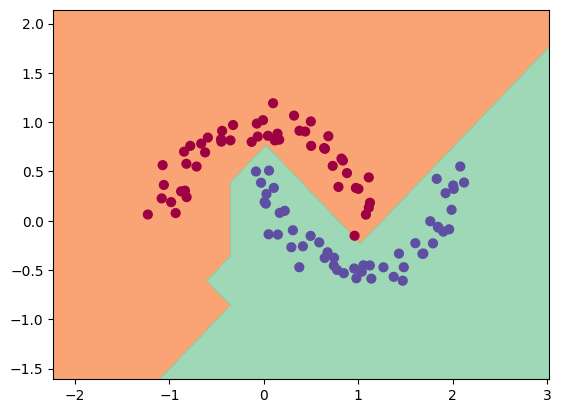

In [37]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())